The following additional libraries are needed to run this
notebook. Note that running on Colab is experimental, please report a Github
issue if you have any problem.

In [ ]:
!pip install d2l==1.0.0-alpha0
!pip install -U mxnet-cu101==1.7.0


# Pretraining BERT
:label:`sec_bert-pretraining`

With the BERT model implemented in :numref:`sec_bert`
and the pretraining examples generated from the WikiText-2 dataset in :numref:`sec_bert-dataset`, we will pretrain BERT on the WikiText-2 dataset in this section.


In [1]:
from mxnet import autograd, gluon, init, np, npx
from d2l import mxnet as d2l

npx.set_np()

To start, we load the WikiText-2 dataset as minibatches
of pretraining examples for masked language modeling and next sentence prediction.
The batch size is 512 and the maximum length of a BERT input sequence is 64.
Note that in the original BERT model, the maximum length is 512.


In [2]:
batch_size, max_len = 512, 64
train_iter, vocab = d2l.load_data_wiki(batch_size, max_len)

## Pretraining BERT

The original BERT has two versions of different model sizes :cite:`Devlin.Chang.Lee.ea.2018`.
The base model ($\text{BERT}_{\text{BASE}}$) uses 12 layers (transformer encoder blocks)
with 768 hidden units (hidden size) and 12 self-attention heads.
The large model ($\text{BERT}_{\text{LARGE}}$) uses 24 layers
with 1024 hidden units and 16 self-attention heads.
Notably, the former has 110 million parameters while the latter has 340 million parameters.
For demonstration with ease,
we define [**a small BERT, using 2 layers, 128 hidden units, and 2 self-attention heads**].


In [3]:
net = d2l.BERTModel(len(vocab), num_hiddens=128, ffn_num_hiddens=256,
                    num_heads=2, num_blks=2, dropout=0.2)
devices = d2l.try_all_gpus()
net.initialize(init.Xavier(), ctx=devices)
loss = gluon.loss.SoftmaxCELoss()

Before defining the training loop,
we define a helper function `_get_batch_loss_bert`.
Given the shard of training examples,
this function [**computes the loss for both the masked language modeling and next sentence prediction tasks**].
Note that the final loss of BERT pretraining
is just the sum of both the masked language modeling loss
and the next sentence prediction loss.


In [4]:
#@save
def _get_batch_loss_bert(net, loss, vocab_size, tokens_X_shards,
                         segments_X_shards, valid_lens_x_shards,
                         pred_positions_X_shards, mlm_weights_X_shards,
                         mlm_Y_shards, nsp_y_shards):
    mlm_ls, nsp_ls, ls = [], [], []
    for (tokens_X_shard, segments_X_shard, valid_lens_x_shard,
         pred_positions_X_shard, mlm_weights_X_shard, mlm_Y_shard,
         nsp_y_shard) in zip(
        tokens_X_shards, segments_X_shards, valid_lens_x_shards,
        pred_positions_X_shards, mlm_weights_X_shards, mlm_Y_shards,
        nsp_y_shards):
        # Forward pass
        _, mlm_Y_hat, nsp_Y_hat = net(
            tokens_X_shard, segments_X_shard, valid_lens_x_shard.reshape(-1),
            pred_positions_X_shard)
        # Compute masked language model loss
        mlm_l = loss(
            mlm_Y_hat.reshape((-1, vocab_size)), mlm_Y_shard.reshape(-1),
            mlm_weights_X_shard.reshape((-1, 1)))
        mlm_l = mlm_l.sum() / (mlm_weights_X_shard.sum() + 1e-8)
        # Compute next sentence prediction loss
        nsp_l = loss(nsp_Y_hat, nsp_y_shard)
        nsp_l = nsp_l.mean()
        mlm_ls.append(mlm_l)
        nsp_ls.append(nsp_l)
        ls.append(mlm_l + nsp_l)
        npx.waitall()
    return mlm_ls, nsp_ls, ls

Invoking the two aforementioned helper functions,
the following `train_bert` function
defines the procedure to [**pretrain BERT (`net`) on the WikiText-2 (`train_iter`) dataset**].
Training BERT can take very long.
Instead of specifying the number of epochs for training
as in the `train_ch13` function (see :numref:`sec_image_augmentation`),
the input `num_steps` of the following function
specifies the number of iteration steps for training.


In [5]:
def train_bert(train_iter, net, loss, vocab_size, devices, num_steps):
    trainer = gluon.Trainer(net.collect_params(), 'adam',
                            {'learning_rate': 0.01})
    step, timer = 0, d2l.Timer()
    animator = d2l.Animator(xlabel='step', ylabel='loss',
                            xlim=[1, num_steps], legend=['mlm', 'nsp'])
    # Sum of masked language modeling losses, sum of next sentence prediction
    # losses, no. of sentence pairs, count
    metric = d2l.Accumulator(4)
    num_steps_reached = False
    while step < num_steps and not num_steps_reached:
        for batch in train_iter:
            (tokens_X_shards, segments_X_shards, valid_lens_x_shards,
             pred_positions_X_shards, mlm_weights_X_shards,
             mlm_Y_shards, nsp_y_shards) = [gluon.utils.split_and_load(
                elem, devices, even_split=False) for elem in batch]
            timer.start()
            with autograd.record():
                mlm_ls, nsp_ls, ls = _get_batch_loss_bert(
                    net, loss, vocab_size, tokens_X_shards, segments_X_shards,
                    valid_lens_x_shards, pred_positions_X_shards,
                    mlm_weights_X_shards, mlm_Y_shards, nsp_y_shards)
            for l in ls:
                l.backward()
            trainer.step(1)
            mlm_l_mean = sum([float(l) for l in mlm_ls]) / len(mlm_ls)
            nsp_l_mean = sum([float(l) for l in nsp_ls]) / len(nsp_ls)
            metric.add(mlm_l_mean, nsp_l_mean, batch[0].shape[0], 1)
            timer.stop()
            animator.add(step + 1,
                         (metric[0] / metric[3], metric[1] / metric[3]))
            step += 1
            if step == num_steps:
                num_steps_reached = True
                break

    print(f'MLM loss {metric[0] / metric[3]:.3f}, '
          f'NSP loss {metric[1] / metric[3]:.3f}')
    print(f'{metric[2] / timer.sum():.1f} sentence pairs/sec on '
          f'{str(devices)}')

We can plot both the masked language modeling loss and the next sentence prediction loss
during BERT pretraining.


MLM loss 7.349, NSP loss 0.829
7299.7 sentence pairs/sec on [gpu(0), gpu(1)]


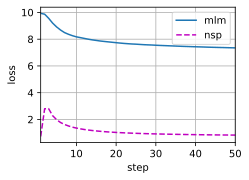

In [6]:
train_bert(train_iter, net, loss, len(vocab), devices, 50)

## [**Representing Text with BERT**]

After pretraining BERT,
we can use it to represent single text, text pairs, or any token in them.
The following function returns the BERT (`net`) representations for all tokens
in `tokens_a` and `tokens_b`.


In [7]:
def get_bert_encoding(net, tokens_a, tokens_b=None):
    tokens, segments = d2l.get_tokens_and_segments(tokens_a, tokens_b)
    token_ids = np.expand_dims(np.array(vocab[tokens], ctx=devices[0]),
                               axis=0)
    segments = np.expand_dims(np.array(segments, ctx=devices[0]), axis=0)
    valid_len = np.expand_dims(np.array(len(tokens), ctx=devices[0]), axis=0)
    encoded_X, _, _ = net(token_ids, segments, valid_len)
    return encoded_X

[**Consider the sentence "a crane is flying".**]
Recall the input representation of BERT as discussed in :numref:`subsec_bert_input_rep`.
After inserting special tokens “&lt;cls&gt;” (used for classification)
and “&lt;sep&gt;” (used for separation),
the BERT input sequence has a length of six.
Since zero is the index of the “&lt;cls&gt;” token,
`encoded_text[:, 0, :]` is the BERT representation of the entire input sentence.
To evaluate the polysemy token "crane",
we also print out the first three elements of the BERT representation of the token.


In [8]:
tokens_a = ['a', 'crane', 'is', 'flying']
encoded_text = get_bert_encoding(net, tokens_a)
# Tokens: '<cls>', 'a', 'crane', 'is', 'flying', '<sep>'
encoded_text_cls = encoded_text[:, 0, :]
encoded_text_crane = encoded_text[:, 2, :]
encoded_text.shape, encoded_text_cls.shape, encoded_text_crane[0][:3]

((1, 6, 128),
 (1, 128),
 array([ 0.80089056,  1.5385284 , -0.32605952], ctx=gpu(0)))

[**Now consider a sentence pair
"a crane driver came" and "he just left".**]
Similarly, `encoded_pair[:, 0, :]` is the encoded result of the entire sentence pair from the pretrained BERT.
Note that the first three elements of the polysemy token "crane" are different from those when the context is different.
This supports that BERT representations are context-sensitive.


In [9]:
tokens_a, tokens_b = ['a', 'crane', 'driver', 'came'], ['he', 'just', 'left']
encoded_pair = get_bert_encoding(net, tokens_a, tokens_b)
# Tokens: '<cls>', 'a', 'crane', 'driver', 'came', '<sep>', 'he', 'just',
# 'left', '<sep>'
encoded_pair_cls = encoded_pair[:, 0, :]
encoded_pair_crane = encoded_pair[:, 2, :]
encoded_pair.shape, encoded_pair_cls.shape, encoded_pair_crane[0][:3]

((1, 10, 128),
 (1, 128),
 array([ 0.80091196,  1.5385116 , -0.3260962 ], ctx=gpu(0)))

In :numref:`chap_nlp_app`, we will fine-tune a pretrained BERT model
for downstream natural language processing applications.


## Summary

* The original BERT has two versions, where the base model has 110 million parameters and the large model has 340 million parameters.
* After pretraining BERT, we can use it to represent single text, text pairs, or any token in them.
* In the experiment, the same token has different BERT representation when their contexts are different. This supports that BERT representations are context-sensitive.


## Exercises

1. In the experiment, we can see that the masked language modeling loss is significantly higher than the next sentence prediction loss. Why?
2. Set the maximum length of a BERT input sequence to be 512 (same as the original BERT model). Use the configurations of the original BERT model such as $\text{BERT}_{\text{LARGE}}$. Do you encounter any error when running this section? Why?


[Discussions](https://discuss.d2l.ai/t/390)
